## Setup
- Imports
- Load and preprocess data

In [2]:
import torch
import torch.nn.functional as F

In [1]:
vocab = [] # all poosible characters in the training corpus
itoc = {} # index to character mapping
ctoi = {} # character to index mapping
for i in range(26):
    c = chr(i+ord('a'))
    vocab.append(c)
    ctoi[c] = i+1
    itoc[i+1] = c

vocab.append('.')
itoc[0] = '.'
ctoi['.'] = 0

In [3]:
with open('./names.txt', 'r') as f:
    words = [word.strip() for word in f.readlines()]

In [38]:
block_size = 3 # previous context size
def create_dataset(names):
    X = []
    y = []
    for name in names:
        context = [0]*block_size # initialize previous context of each word with '...', which translates to [0,0,0] indices in the vocab
        for c in name.strip() + '.': # append '.' to the end of name to capture ending sequences of each name
            label = ctoi[c] # vocab index of the current character in name
            X.append(context)
            y.append(label)
            context = context[1:] + [label]
    return torch.tensor(X), torch.tensor(y)

import random
random.seed(1937)
random.shuffle(words) # randomly shuffles the list of words, reduces the gap between train/dev errors! WHY??!
total_data_size = len(words)
train_size = int(total_data_size*0.8)
dev_size = int(total_data_size*0.1)
Xtr, ytr = create_dataset(words[:train_size])
Xdev, ydev = create_dataset(words[train_size:train_size+dev_size])
Xtest, ytest = create_dataset(words[train_size+dev_size:])


## Build the MLP
- will be used as reference for explanations ahead in the code

In [39]:
g = torch.Generator().manual_seed(66449941) # for reproducibility
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn((hidden_layer_size), generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)
b2 = torch.randn((output_layer_size), generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

9367

In [41]:
log_losses = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    a1 = torch.tanh((emb.view(-1, block_size*emb_dimensions) @ W1 + b1))
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad
    log_losses.append(loss.log10().item())

      0/ 200000: 17.0453
  10000/ 200000: 2.1651
  20000/ 200000: 2.3421
  30000/ 200000: 2.5685
  40000/ 200000: 2.0644
  50000/ 200000: 2.3014
  60000/ 200000: 2.2805
  70000/ 200000: 2.4262
  80000/ 200000: 2.0969
  90000/ 200000: 2.2885
 100000/ 200000: 2.2696
 110000/ 200000: 2.2033
 120000/ 200000: 2.1952
 130000/ 200000: 2.4137
 140000/ 200000: 2.1973
 150000/ 200000: 2.1784
 160000/ 200000: 2.5361
 170000/ 200000: 2.2473
 180000/ 200000: 2.0071
 190000/ 200000: 2.1565


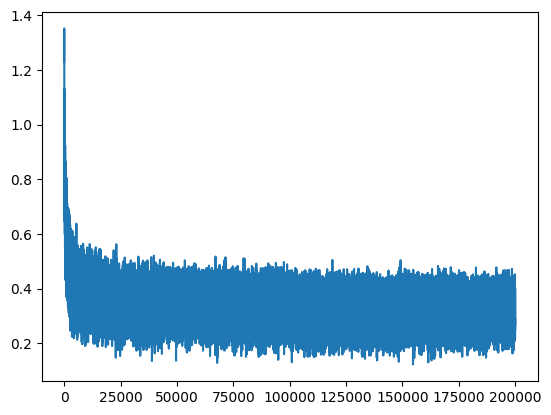

In [42]:
from matplotlib import pyplot as plt
plt.plot(log_losses)

In [29]:
@torch.no_grad()
def evaluate(split):
    X, y = {'train':[Xtr, ytr],
            'dev':[Xdev, ydev],
            'test':[Xtest, ytest]
            }[split]
    emb = C[X]
    a1 = torch.tanh(emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    logits = a1 @ W2 + b2
    return F.cross_entropy(logits, y).item()

In [43]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.115313768386841, 2.1721436977386475, 2.1816470623016357)

## Fixing initial loss

#### expected inital loss
- first we need to set the right expectations
- what can be the worst possible initial loss?
    - depends on the problem and the loss function
    - almost always possible to estimate this quantity beforehand
    - helps start strong in training loop
- In our case worst loss intial loss:
    - negative log likelihood
    - worst possible model would be when the prob of each token coming next is equal = 1/vocab_size => model hasen't learnt anything
    - we take only 1/vocab_size [single probability] as we are predicting single token
    - in our case that's prob = 1/27.0 => negative log likelihood = -log(prob) ~ (3,4)
- but the initial loss we got is 17 which is way off [though its averaged over 1st mini-batch]
- this is due to improper initialization of parameters

In [47]:
expected_loss = -torch.tensor(1/27.0).log()
expected_loss

tensor(3.2958)

#### example of issue
- vocab = [a, b, c, d], vocab_size = 4
- if logits are almost equal, the softmax probs would also be almost equal and
- hence the loss would be approx equal to expected loss = -log(1/4.0) ~ 1.39

In [49]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) # say we got these logits from the intial model parameters [0th iteration -> no learning yet]
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

- as we can see, equal probabilities and hence got expected loss
- another example
    - say due to initialization we accidentally get too high logit value for the expected next token in the minibatch examples
    - and very low logits for the other tokens
    - then initial loss would be very low than expected worst case!!

In [50]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0]) # high logit for 'c' token
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

- loss is almost zero!!
- another example
    - now let's set logits higher for unexpected tokens and lower for expected token
    - loss would be higher than expected worst case

In [51]:
logits = torch.tensor([0.0, 5.0, 0.0, 0.0]) # high logit for 'c' token
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
probs, loss

(tensor([0.0066, 0.9802, 0.0066, 0.0066]), tensor(5.0200))

- let's now experiment with logits drawn from gaussian distribution (0,1)
    - if we try executing the below cell multiple times, we may get loss anywhere between (0,5-6)
    - still okay as the logits will be somewhere between -3 and 3 mostly (6-sigma)

In [94]:
logits = torch.randn(4) # values drawn from normal dist, hence mostly close to zero
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
logits, probs, loss

(tensor([ 1.6604,  0.3079, -0.4316,  0.8718]),
 tensor([0.5445, 0.1408, 0.0672, 0.2475]),
 tensor(2.6998))

- if we use very extreme values (far away from 0), we might get very high/low loss

In [97]:
logits = torch.randn(4)*10 # now logits mostly lie between [-30, 30] 6-sigma*10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
logits, probs, loss

(tensor([11.3478,  3.8213,  2.0427,  1.5920]),
 tensor([9.9931e-01, 5.3826e-04, 9.0898e-05, 5.7919e-05]),
 tensor(9.3058))

In [102]:
logits = torch.randn(4)*100 # now logits mostly lie between [-300, 300] 6-sigma*100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # peek into the probability of the token 'c' appearing next and calculate the nll
logits, probs, loss

(tensor([-41.6019, 195.6921, -70.2348,  61.4994]),
 tensor([0., 1., 0., 0.]),
 tensor(inf))

Summary:
- we want the logits to be equal initially to get the expected loss
- can be any number (remember softmax in shift invariant! refer previous notebooks)
- better to stick with 0 initialization

#### Fix issue in model params

from prev section:
- we need to get the logits as close to 0 and as equal in magnitude as possible
- how can we achieve this?
    - observe the computation of logits
    - logits = 
    - setting the last layer weights and biases to 0 W2=b2=0 [this can lead to problems as discussed later in this notebook]
    - instead set W2 to very low values close to 0 and b2 to exactly 0

In [112]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

11897

In [113]:
log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    a1 = torch.tanh((emb.view(-1, block_size*emb_dimensions) @ W1 + b1))
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.2818
  10000/ 200000: 1.9967
  20000/ 200000: 2.1044
  30000/ 200000: 2.3582
  40000/ 200000: 2.5299
  50000/ 200000: 2.3278
  60000/ 200000: 1.9905
  70000/ 200000: 2.2069
  80000/ 200000: 2.1595
  90000/ 200000: 2.5824
 100000/ 200000: 1.9348
 110000/ 200000: 2.0562
 120000/ 200000: 2.4081
 130000/ 200000: 2.2449
 140000/ 200000: 2.0295
 150000/ 200000: 1.7764
 160000/ 200000: 1.9497
 170000/ 200000: 1.5519
 180000/ 200000: 1.8551
 190000/ 200000: 2.0702


- we got a initial loss close to the expected worst case loss!

In [115]:
# scrutinize the logits for 1st example
logits[0]

tensor([ 2.5992,  3.6125,  3.3218, -0.4748, -1.2843,  3.0023, -2.8475,  0.8144,
        -3.0743,  3.7589, -1.1597, -2.9218, -0.8701,  2.4202, -0.1275,  3.5110,
         0.8811, -3.5731,  1.0918,  0.4604, -3.5638,  1.6311, -3.7558, -2.9542,
        -2.7588,  1.4990,  0.5648], grad_fn=<SelectBackward0>)

- small numbers close to zero as expected
- let's also visualize the log loss plot with steps

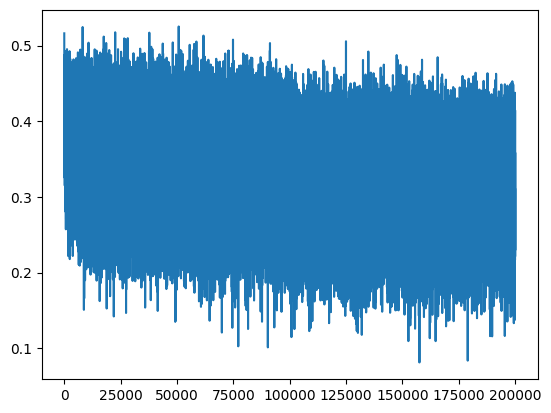

In [114]:
from matplotlib import pyplot as plt
plt.plot(log_losses)

- notice how the hockey stick like loss curve has changed to the unstable part only
- because, earlier NN was able to squash the final logits and learn quickly in the initial iterations
- now we took the easier part away by better param initialization
- the hard part remains

let's also check the dev loss

In [117]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.064671516418457, 2.1371400356292725, 2.147270679473877)

the loss actually improved on all three splits!
- mainly because we let the model focus more on the actual learning part
- and not the logit squashing part
- hence, initialization part has been taken care of

There is another problem in the NN:
- the activations
- we have used tanh activation function that maps Real numbers between -1 and 1
- 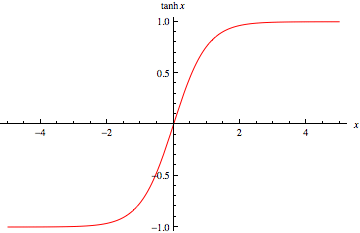

- notice how the activations would be mostly close to 1 and -1 if the tanh abs input value is >=2.5
- this also means the gradients would be close to 0 and minimal updates to the NN params!

## Activation issue
- let's analyze the activations of the hidden layer for better intuition

#### activations analysis thru dist, visualization

In [127]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

11897

In [128]:

log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    break # to see the activations and analyze
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.3376


In [129]:
# activations - see how most of them are close to one
a1

tensor([[ 1.0000,  0.3330, -0.9425,  ..., -0.9862, -1.0000, -0.9986],
        [-0.8950,  0.9878,  0.9589,  ...,  0.4622, -0.9999,  0.7508],
        [ 0.9901, -0.9997, -0.9976,  ...,  0.9999, -1.0000, -0.9996],
        ...,
        [-1.0000,  1.0000,  0.9999,  ...,  0.9912,  1.0000, -1.0000],
        [-0.9997, -0.8327,  0.9912,  ...,  1.0000, -1.0000, -0.9464],
        [-1.0000, -0.9999,  1.0000,  ..., -0.9973, -1.0000, -0.6694]],
       grad_fn=<TanhBackward0>)

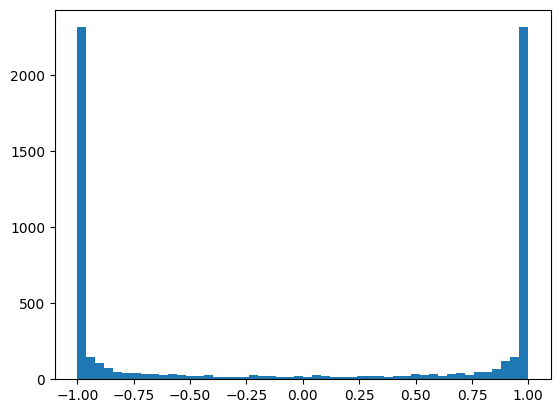

In [130]:
# drawing histogram
activations = a1.view(-1).tolist()
plt.hist(activations, bins = 50); # semi-colon suppresses the unwanted output

why mostly close to 1 or -1?
- check tanh input dist

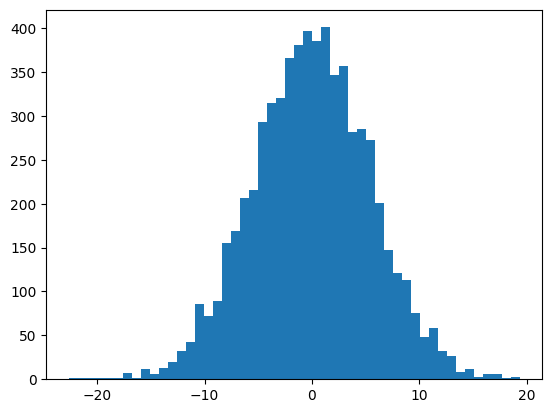

In [131]:
plt.hist(z1.view(-1).tolist(), 50);

In [143]:
# number of abs values greater than 2.5
total_preactivations = z1.view(-1).shape[0]
tail_region_preactivations = torch.where(torch.abs(z1.view(-1)) > 2.5)[0].shape[0]
tail_region_preactivations, total_preactivations

(4146, 6400)

- range of values of the pre-activations is very broad [-15, 15]
- majority lie in the tail/flat region of tanh as seen in prev cell

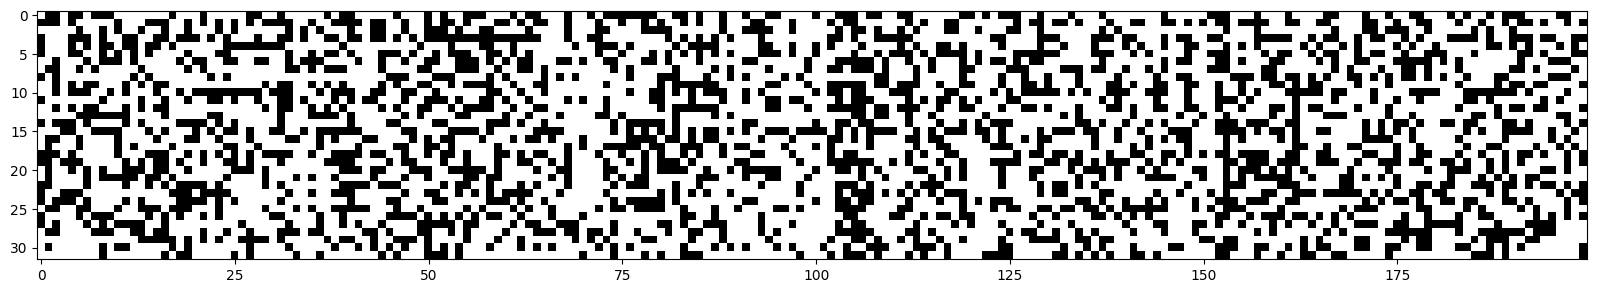

In [147]:
# we an even visualize the activations in a better way
plt.figure(figsize=(20,10))
plt.imshow(a1.abs()>0.99, cmap='gray', interpolation='nearest') # white means how many activations are close to 1
# 32x200 sized boolean tensor of activation absolute values > 0.99

majority are whites
- this represents 32 examples in the minibatch and the 200 neurons in hidden layer
- if by any chance the weights and biases are initialized such that 
- one of the neurons has activations 1 for all the examples, that neuron won't be learning!!
- dL/dz = (dL/da)*(da/dz) = (dL/da)*0.00000000001 ~ 0
- z = z - dL/dz; z = z => hence, the weights and biases coming in to this neuron won't update => DEAD NEURON
- not only the gradient part, but for some activation functions like ReLU, if the learning rate is too high, some activations might get knocked out into the flat region leading to permanent damage [no learning ever after]

#### How do we solve for this issue?
- similar to previous issue, where we set the weights and biases so that logits are closer to 0 and more uniform
- we would set the weights and biases leading to the pre-activations to lower values close to 0
- this would force pre-activations closer to 0 [-1, 1] and hence push activations in the active region of tanh

In [159]:
g = torch.Generator().manual_seed(66449941)
vocab_size = len(vocab)
emb_dimensions = 10
hidden_layer_size = 200
output_layer_size = vocab_size
C = torch.randn((vocab_size, emb_dimensions), generator=g)
W1 = torch.randn((block_size*emb_dimensions, hidden_layer_size), generator = g)*0.2
b1 = torch.randn(hidden_layer_size, generator=g)*0.01
W2 = torch.randn((hidden_layer_size, output_layer_size), generator = g)*0.01
b2 = torch.randn((output_layer_size), generator = g)*0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

total_parameters = sum(p.nelement() for p in parameters)
total_parameters

11897

In [154]:

log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability
    break # to see the activations and analyze
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.3022


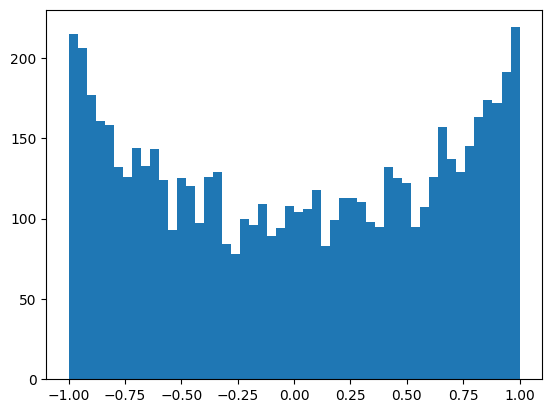

In [155]:
plt.hist(a1.view(-1).tolist(), bins = 50);

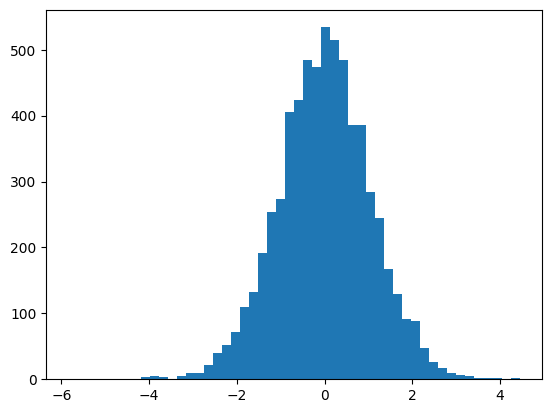

In [156]:
plt.hist(z1.view(-1).tolist(), 50);

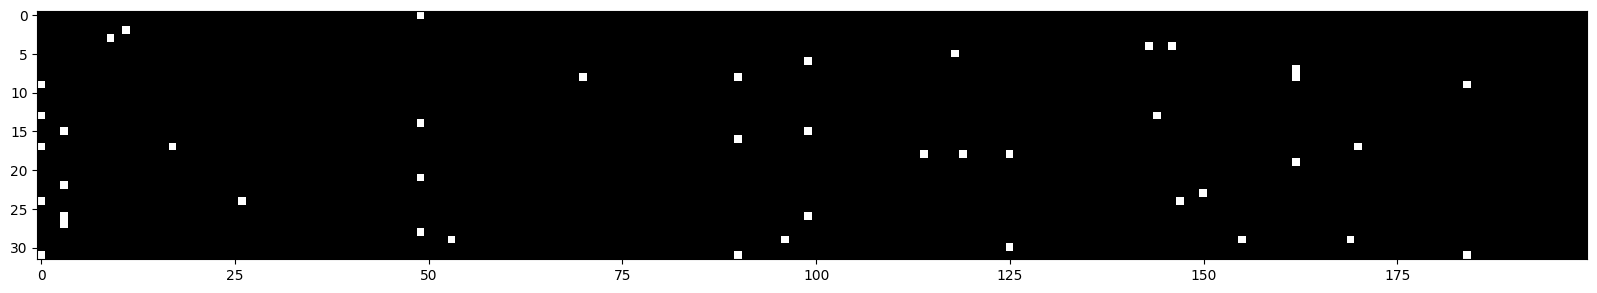

In [158]:
plt.figure(figsize=(20,10))
plt.imshow(a1>0.99, cmap='gray', interpolation='nearest')

- most activations are now in active region
- let's retrain the model with this config now

#### re-training post activation fix

In [160]:

log_losses = []
steps = []
num_iterations = 200000
mini_batch_size = 32

for i in range(num_iterations):
    # randomly sample minibatch indices
    ix = torch.randint(0, Xtr.shape[0], (mini_batch_size,))
    # forward pass
    emb = C[Xtr[ix]]
    z1 = (emb.view(-1, block_size*emb_dimensions) @ W1 + b1)
    a1 = torch.tanh(z1)
    logits = a1 @ W2 + b2
    loss = F.cross_entropy(logits, ytr[ix])
    if i%10000==0:
        print(f'{i:7d}/{num_iterations:7d}: {loss.item():.4f}') # 7d aligns the outputs for readability

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    learning_rate = 0.1 if i < num_iterations//2 else 0.01
    for p in parameters:
        p.data += -learning_rate*p.grad

    steps.append(i)
    log_losses.append(torch.log10(loss).item())

      0/ 200000: 3.3095
  10000/ 200000: 2.4105
  20000/ 200000: 2.1044
  30000/ 200000: 2.1873
  40000/ 200000: 1.8532
  50000/ 200000: 1.8612
  60000/ 200000: 2.0871
  70000/ 200000: 2.0384
  80000/ 200000: 2.3845
  90000/ 200000: 1.7818
 100000/ 200000: 1.9241
 110000/ 200000: 2.1661
 120000/ 200000: 2.0970
 130000/ 200000: 2.3377
 140000/ 200000: 1.9109
 150000/ 200000: 2.1244
 160000/ 200000: 2.0043
 170000/ 200000: 1.5509
 180000/ 200000: 2.2036
 190000/ 200000: 2.3006


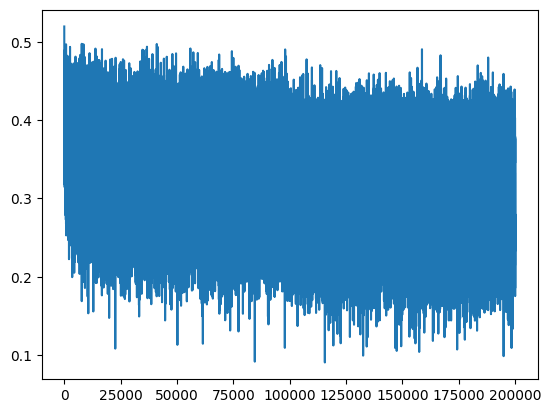

In [161]:
plt.plot(log_losses)

In [162]:
evaluate('train'), evaluate('dev'), evaluate('test')

(2.036219835281372, 2.109724283218384, 2.118234395980835)

Losses on train/dev:
- stage:             train,  dev
- initial:           2.12,   2.17
- logits fix:        2.07,   2.14
- activations fix:   2.04,   2.11

we have made improvements but we are heavily dependent on scaling the initialized parameters. We came up with random set of scaling factors which obviously is not the best way to solve these issues.
- Let's look at how we can account for this much elegantly

## Kaiming Normalization

#### Proof of concept

tensor(-0.0094) tensor(0.9982)
tensor(0.0038) tensor(3.1372)


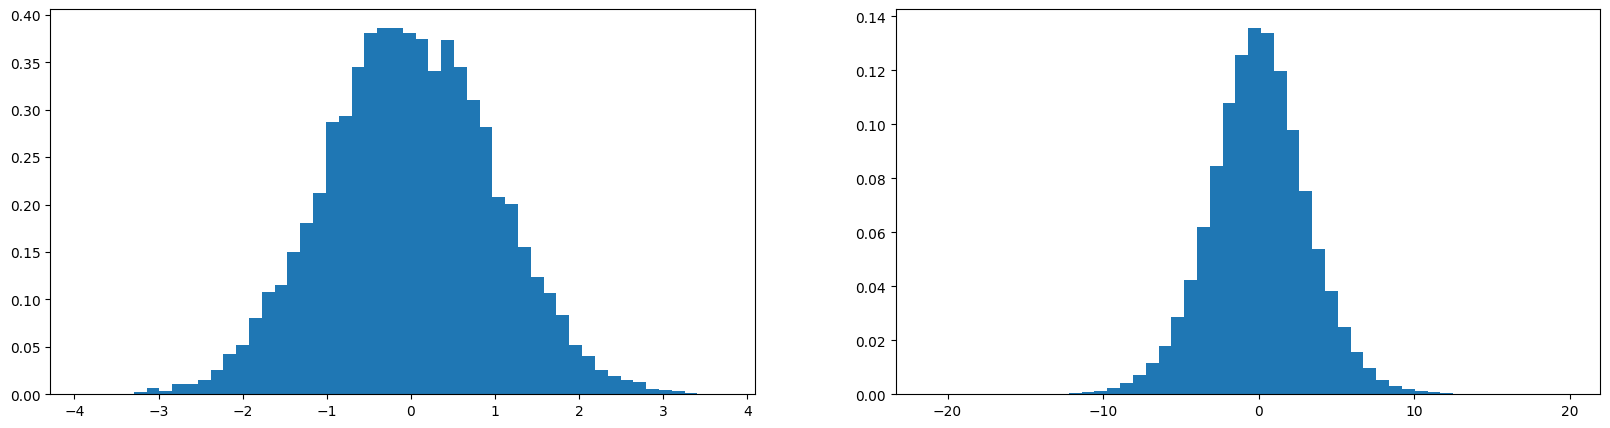

In [164]:
x = torch.randn(1000, 10) # 1000 examples drawn from gaussian; 10d input
w = torch.randn(10, 200) # gaussian weights 10; 200 output size
y = x@w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

- x mean is 0 and std 1 which is expected
- y mean is 0 as x@w is symmetric operation
- but y std is 3 => broader gaussian
- what we want is unit gaussians throughout the network to ensure we hit the active regions of the activation functions
- we have seen earlier, scaling down the weights w can solve this issue
- but what is the scaling factor?

tensor(-0.0124) tensor(0.9915)
tensor(0.0015) tensor(1.0097)


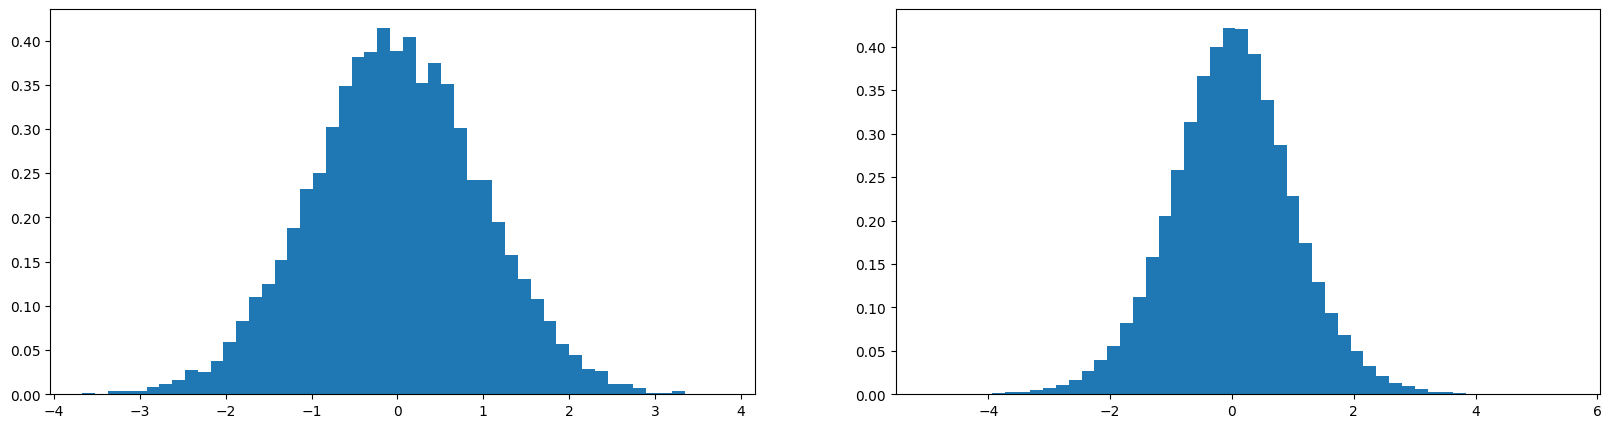

In [169]:
x = torch.randn(1000, 10) # 1000 examples drawn from gaussian; 10d input
w = torch.randn(10, 200)*(1/10**0.5) # gaussian weights input size 10; 200 output size
y = x@w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True);

- scaling factor of 0.2 reduced the std to 0.62 which is too low
- scaling factor of 0.6 lead to std = 1.9 too high
- how do we find the sweet spot for scaling factor??
- one idea is kaiming scaling of either activations or gradients in forward or bacward pass respectively [refer paper]
- kaiming normalization factor in forward pass = activation_gain/(fan_in_layre_size**0.5)
- activation_gain is specific to the activation function
- above example is linear activation/no activation, hence the gain is 1 and factor is 1/(10**0.5)
- now the std of y's comes out to be 1

gain for tanh is 5/3; fan-in is emb_dimension*block_size
- comes out to be 0.3 which is very close to 0.2 that we tried out
- hence no point in re-training, we would get similar results

## Batch Normalization

In [ ]:
# video timestamp 40.37